In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from itertools import groupby
from pylab import *


rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
matplotlib.rcParams.update({'font.size': 12})

In [2]:
def all_equal(iterable):
    g = groupby(iterable)
    return next(g, True) and not next(g, False)

In [3]:
class Graph_oop:
    def __init__(self, lamda_1, lamda_2, p_1, p_2, 
                 N, share_of_casualties, t_travel, number_of_vertices):
        self.number_of_vertices = number_of_vertices
        self.lamda_1 = lamda_1
        self.lamda_2 = lamda_2
        self.p_1 = p_1
        self.p_2 = p_2

        self.N = N
        self.share_of_casualties = share_of_casualties

        self.t_travel = t_travel

    def calculate(self):
        N1_0_start = list(np.zeros(self.number_of_vertices))
        N2_0_start = list(np.zeros(self.number_of_vertices))
        for i in range(1, self.number_of_vertices+1):
            N1_0_start[i-1] = [self.N['1-{}'.format(str(i))]]
            N2_0_start[i-1] = [self.N['2-{}'.format(str(i))]]
        N1_0_start = np.array(N1_0_start)
        N2_0_start = np.array(N2_0_start)

        share_of_casualties_1 = np.array([])
        share_of_casualties_2 = np.array([])
        for i in range(1, self.number_of_vertices+1):
            share_of_casualties_1 = np.append(share_of_casualties_1, self.share_of_casualties['1-{}'.format(str(i))])
            share_of_casualties_2 = np.append(share_of_casualties_2, self.share_of_casualties['2-{}'.format(str(i))])
        
        tau = 0 # общее время
        dt = 1e-2 # шаг по времени

        a_1 = self.lamda_1 * self.p_1
        a_2 = self.lamda_2 * self.p_2
        
        # Начальные численности сторон в вершинах
        # номер стороны, номер вершины

        N1_0 = np.zeros(self.number_of_vertices)
        N2_0 = np.zeros(self.number_of_vertices)
        for i in range(1, self.number_of_vertices+1):
            N1_0[i-1] = self.N['1-{}'.format(str(i))]
            N2_0[i-1] = self.N['2-{}'.format(str(i))]
        
        # Текущие численности сторон в вершинах
        # номер стороны, номер вершины
        N1 = np.zeros(self.number_of_vertices)
        N2 = np.zeros(self.number_of_vertices)
        for i in range(1, self.number_of_vertices+1):
            N1[i-1] = self.N['1-{}'.format(str(i))]
            N2[i-1] = self.N['2-{}'.format(str(i))]

        # добавлять массив массивов, а не все в одно
        t_arr = np.array([tau])
        N1_arr = list(np.zeros(self.number_of_vertices))
        N2_arr = list(np.zeros(self.number_of_vertices))
        for i in range(1, self.number_of_vertices+1):
            N1_arr[i-1] = np.array([N1[i-1]])
            N2_arr[i-1] = np.array([N2[i-1]])

        # флаг отступила ли сторона
        # номер стороны, номер вершины
        flag_of_retreat = {}
        for i in range(1, self.number_of_vertices+1):
            flag_of_retreat["1-{}".format(str(i))] = 0
            flag_of_retreat["2-{}".format(str(i))] = 0

        # матрица управляющих воздействий
        # номер стороны, номер вершины, направление
        matrix_of_travels = {}
        for i in range(1, self.number_of_vertices+1):
                for j in range(1, self.number_of_vertices+1):
                    if j!=i:
                        matrix_of_travels["1-{}-{}".format(str(i), str(j))] = 0
                        matrix_of_travels["2-{}-{}".format(str(i), str(j))] = 0
        
        # Матрица времени ожидаемых подкреплений
        # Номер стороны, номер выршины, направление
        t_of_expected_reinforcments = {}
        for i in range(1, self.number_of_vertices+1):
                for j in range(1, self.number_of_vertices+1):
                    if j!=i:
                        t_of_expected_reinforcments["1_{}-{}".format(str(i), str(j))] = 0
                        t_of_expected_reinforcments["2_{}-{}".format(str(i), str(j))] = 0
        
        # матрица отступлений, исторические данные
        # Номер стороны, номер выршины
        matrix_of_retreats = {}
        for i in range(1, self.number_of_vertices+1):
            matrix_of_retreats["1-{}".format(str(i))] = 0
            matrix_of_retreats["2-{}".format(str(i))] = 0

        t_travel = self.t_travel
        
        while (tau <= 1e1) and ((N1.sum() > 1) and (N2.sum() > 1)):
            tau += dt
        
            # Расчет порога для отступления
            N1_for_retreat = N1_0 * share_of_casualties_1
            N2_for_retreat = N2_0 * share_of_casualties_2
            # приход подкреплений
            for i in range(1, self.number_of_vertices+1):
                for j in range(1, self.number_of_vertices+1):
                    if i!=j:
                        if round(tau, 5) == round(t_of_expected_reinforcments['1_{}-{}'.format(str(i), str(j))], 5):
                            t_of_expected_reinforcments['1_{}-{}'.format(str(i), str(j))] = 0
                            N1_0[j-1] += N1[i-1]
                            N1[j-1] += N1[i-1]
                            N1[i-1]=0
                            N1_for_retreat[i-1]=-1
                            N2[i-1]=0
                        if round(tau, 5) == round(t_of_expected_reinforcments['2_{}-{}'.format(str(i), str(j))], 5):
                            t_of_expected_reinforcments['2_{}-{}'.format(str(i), str(j))] = 0
                            N2_0[j-1] += N2[i-1]
                            N2[j-1] += N2[i-1]
                            N2_for_retreat[i-1]=-1
                            N2[i-1]=0
                            N1[i-1]=0
        
            # Расчет текущей численности сторон
            dN1 = -a_2 * N2 * N1/N1_0 * dt
            dN2 = -a_1 * N1 * N2/N2_0 * dt
            N1 += dN1
            N2 += dN2

            t_arr = np.append(t_arr, tau)
            for i in range(1, self.number_of_vertices+1):
                N1_arr[i-1] = np.append(N1_arr[i-1], N1[i-1])
                N2_arr[i-1] = np.append(N2_arr[i-1], N2[i-1])

            # Проверка было ли отступление
            for i in range(1, self.number_of_vertices+1):
                if (N1[i-1] <= N1_for_retreat[i-1]) and (matrix_of_retreats['1-{}'.format(str(i))] == 0):
                    flag_of_retreat['1-{}'.format(str(i))] = 1
                    N1[i-1] = 0
                    matrix_of_retreats['1-{}'.format(str(i))] = 1

                if (N2[i-1] <= N2_for_retreat[i-1]) and (matrix_of_retreats['2-{}'.format(str(i))] == 0):
                    flag_of_retreat['2-{}'.format(str(i))] = 1
                    N2[i-1] = 0
                    matrix_of_retreats['2-{}'.format(str(i))] = 1
                
            # ФУНКЦИЯ УПРАВЛЕНИЯ
            # Условие:
            # В приорите получает подкрепление сторона, которая понесла большие потери
            # Если потери равны, подкрепления идут в вершину, с наим. времени пути
            for i in range(1, self.number_of_vertices+1):
                if flag_of_retreat['1-{}'.format(str(i))] == 1:
                    flag_of_retreat['1-{}'.format(str(i))] = 0
                    for j in range(1, self.number_of_vertices+1):
                        if i!=j:                          
                            relation_of_loses = np.round(N2/N2_0, 2)
                            for k in range(len(relation_of_loses)):
                                if relation_of_loses[k] == 0:
                                    relation_of_loses[k] = 1
                            if all_equal(relation_of_loses):
                                filt_dict = {k: v for k, v in t_travel.items() if k.startswith('{}-'.format(str(i)))}
                                matrix_of_travels['2-{}'.format(min(filt_dict, key=filt_dict.get))] = 1
                            else:
                                graph_vetice_for_reinforcement = relation_of_loses.argmin() + 1
                                matrix_of_travels['2-{}-{}'.format(str(i), str(graph_vetice_for_reinforcement))] = 1

                if flag_of_retreat['2-{}'.format(str(i))] == 1:
                    flag_of_retreat['2-{}'.format(str(i))] = 0
                    for j in range(1, self.number_of_vertices+1):
                        if i!=j:
                            relation_of_loses = np.round(N1/N1_0, 2)
                            for k in range(len(relation_of_loses)):
                                if relation_of_loses[k] == 0:
                                    relation_of_loses[k] = 1
                            if all_equal(relation_of_loses):
                                filt_dict = {k: v for k, v in t_travel.items() if k.startswith('{}-'.format(str(i)))}
                                matrix_of_travels['1-{}'.format(min(filt_dict, key=filt_dict.get))] = 1
                            else:
                                graph_vetice_for_reinforcement = relation_of_loses.argmin() + 1
                                matrix_of_travels['1-{}-{}'.format(str(i), str(graph_vetice_for_reinforcement))] = 1

        
            # Расчет времени прибытия подкреплений
            for i in range(1, self.number_of_vertices+1):
                for j in range(1, self.number_of_vertices+1):
                    if j!=i:
                        if matrix_of_travels['2-{}-{}'.format(str(i), str(j))] == 1:
                            matrix_of_travels['2-{}-{}'.format(str(i), str(j))] = 0
                            t_of_expected_reinforcments['2_{}-{}'.format(str(i), str(j))] = tau + t_travel['{}-{}'.format(str(i), str(j))]
                        if matrix_of_travels['1-{}-{}'.format(str(i), str(j))] == 1:
                            matrix_of_travels['1-{}-{}'.format(str(i), str(j))] = 0
                            t_of_expected_reinforcments['1_{}-{}'.format(str(i), str(j))] = tau + t_travel['{}-{}'.format(str(i), str(j))]


        return t_arr, N1_arr, N2_arr

    def plot_results(self):
        
        t_arr, N1_arr, N2_arr= self.calculate()
        number_of_vertices = self.number_of_vertices

        plt.figure(figsize=(12, self.number_of_vertices*6))
        subplots_adjust(hspace=0.15)

        for i,v in enumerate(range(self.number_of_vertices)):
            v = v+1
            ax1 = subplot(number_of_vertices,1,v)
            ax1.set_title('Вершина {}'.format(str(i+1)))
            ax1.plot(t_arr, N1_arr[i], label='Первая сторона, λ = {} выст/ед. врем, $p$ = {}'.format(self.lamda_1, self.p_1), color='#A60000')
            ax1.plot(t_arr, N2_arr[i], label='Вторая сторона, λ = {} выст/ед. врем, $p$ = {}'.format(self.lamda_2, self.p_2), color='#008500', alpha=0.7)
            ax1.plot([t_arr[0], t_arr[-1]], [self.N['1-{}'.format(str(i+1))]*self.share_of_casualties['1-{}'.format(str(i+1))], 
                                             self.N['1-{}'.format(str(i+1))]*self.share_of_casualties['1-{}'.format(str(i+1))]], 
                     linestyle=':', color='black', label='Порог для отступления первой стороны')
            ax1.plot([t_arr[0], t_arr[-1]], [self.N['2-{}'.format(str(i+1))]*self.share_of_casualties['2-{}'.format(str(i+1))], 
                                             self.N['2-{}'.format(str(i+1))]*self.share_of_casualties['2-{}'.format(str(i+1))]], 
                     linestyle='--', color='black', label='Порог для отступления второй стороны')
            ax1.grid()
            ax1.legend()
        
        plt.show()

In [4]:
graph_1 = Graph_oop(lamda_1=3.1, lamda_2=3, p_1=0.6, p_2=0.6, 
                N=
                        {'1-1':1000, '2-1':1000,
                        '1-2':1000, '2-2':1000,
                        '1-3':1000, '2-3':1000}, 
                share_of_casualties=
                        {'1-1':0.7, '2-1':0.7,
                        '1-2':0.15, '2-2':0.15,
                        '1-3':0.01, '2-3':0.01},
                t_travel=
                        {'1-2':1e-2, '2-1':1e-2,
                        '2-3':1e-2, '3-2':1e-2,
                        '1-3':1e-2,'3-1':1e-2}, 
                number_of_vertices=3)

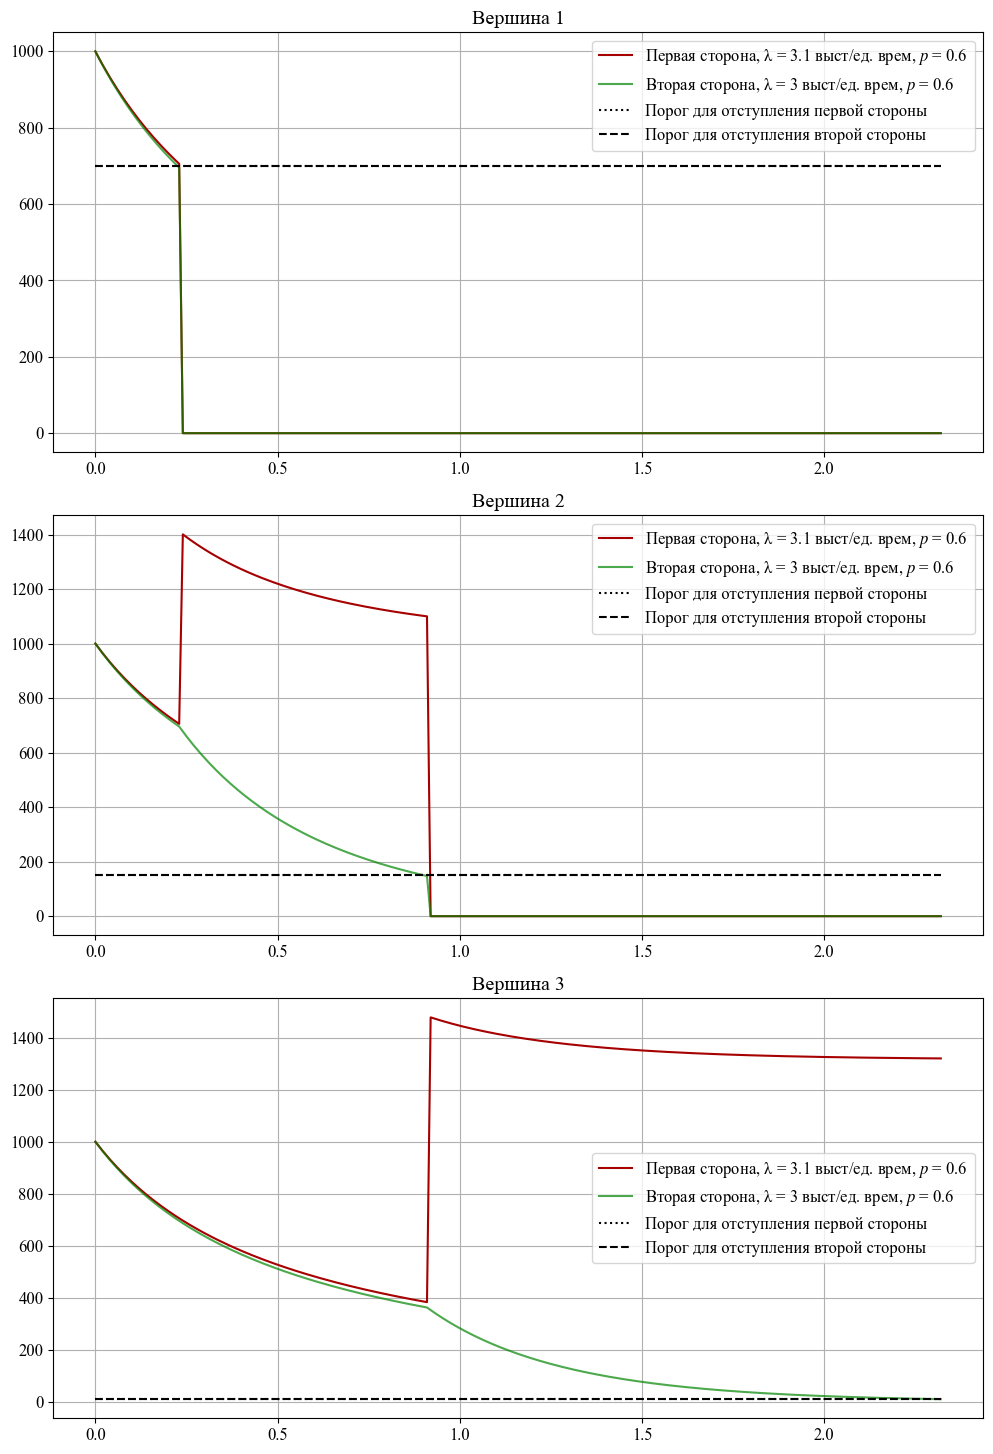

In [5]:
graph_1.plot_results()

In [6]:
graph_2 = Graph_oop(lamda_1=3.1, lamda_2=3, p_1=0.6, p_2=0.6, 
                N=
                        {'1-1':1000, '2-1':1000,
                        '1-2':1000, '2-2':1000,
                        '1-3':1000, '2-3':1000,
                        '1-4':1000, '2-4':1000}, 
                share_of_casualties=
                        {'1-1':0.7, '2-1':0.7,
                        '1-2':0.35, '2-2':0.35,
                        '1-3':0.1, '2-3':0.1,
                        '1-4':0.01, '2-4':0.01},
                t_travel=
                        {'1-2':1e-2, '2-1':1e-2,
                        '2-3':1e-2, '3-2':1e-2,
                        '1-3':1e-2,'3-1':1e-2,
                        '1-4':1e-2,'4-1':1e-2,
                        '2-4':1e-2,'4-2':1e-2,
                        '3-4':1e-2,'4-3':1e-2}, 
                number_of_vertices=4)

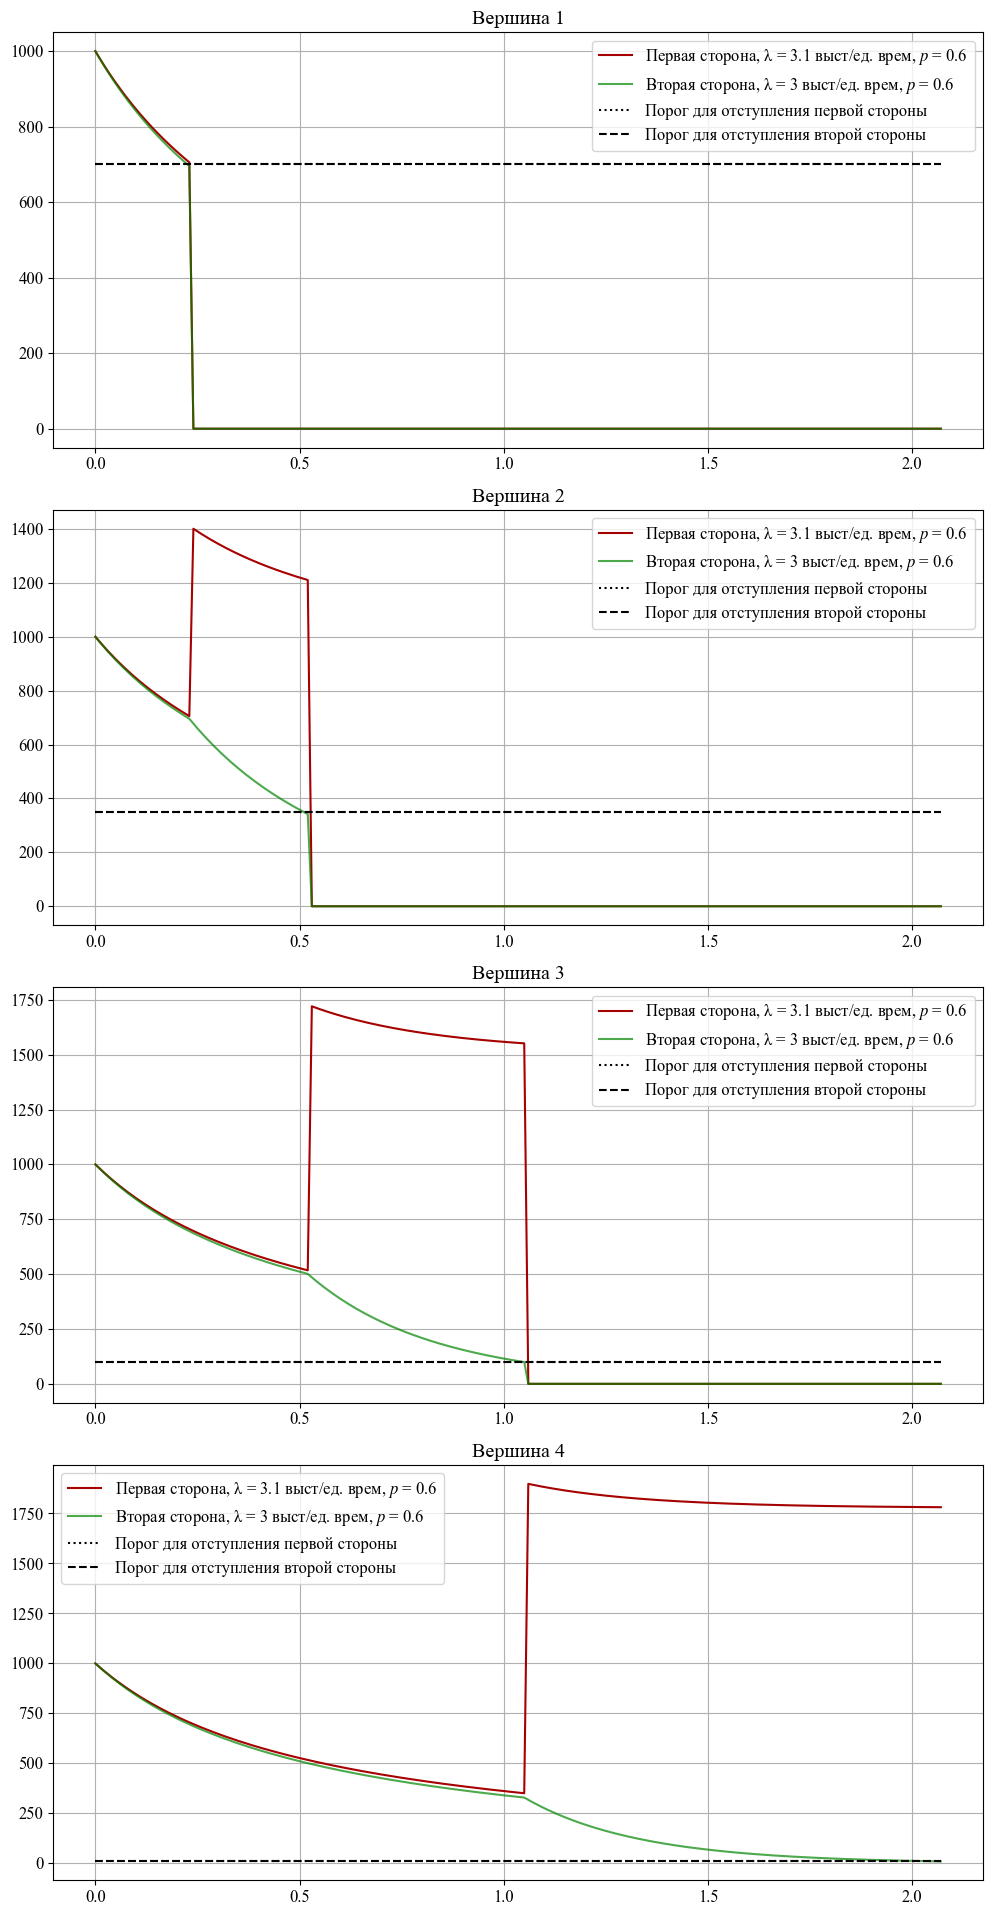

In [7]:
graph_2.plot_results()

In [8]:
graph_3 = Graph_oop(lamda_1=3.1, lamda_2=3, p_1=0.6, p_2=0.6, 
                N=
                        {'1-1':1000, '2-1':1000,
                        '1-2':1000, '2-2':1000,
                        '1-3':1000, '2-3':1000,
                        '1-4':1000, '2-4':1000,
                        '1-5':1000, '2-5':1000}, 
                share_of_casualties=
                        {'1-1':0.7, '2-1':0.7,
                        '1-2':0.45, '2-2':0.45,
                        '1-3':0.2, '2-3':0.2,
                        '1-4':0.1, '2-4':0.1,
                        '1-5':0.01, '2-5':0.01},
                t_travel=
                        {'1-2':1e-2, '2-1':1e-2,
                        '2-3':1e-2, '3-2':1e-2,
                        '1-3':1e-2,'3-1':1e-2,
                        '1-4':1e-2,'4-1':1e-2,
                        '2-4':1e-2,'4-2':1e-2,
                        '3-4':1e-2,'4-3':1e-2,
                        '1-5':1e-2,'5-1':1e-2,
                        '2-5':1e-2,'5-2':1e-2,
                        '3-5':1e-2,'5-3':1e-2,
                        '4-5':1e-2,'5-4':1e-2}, 
                number_of_vertices=5)

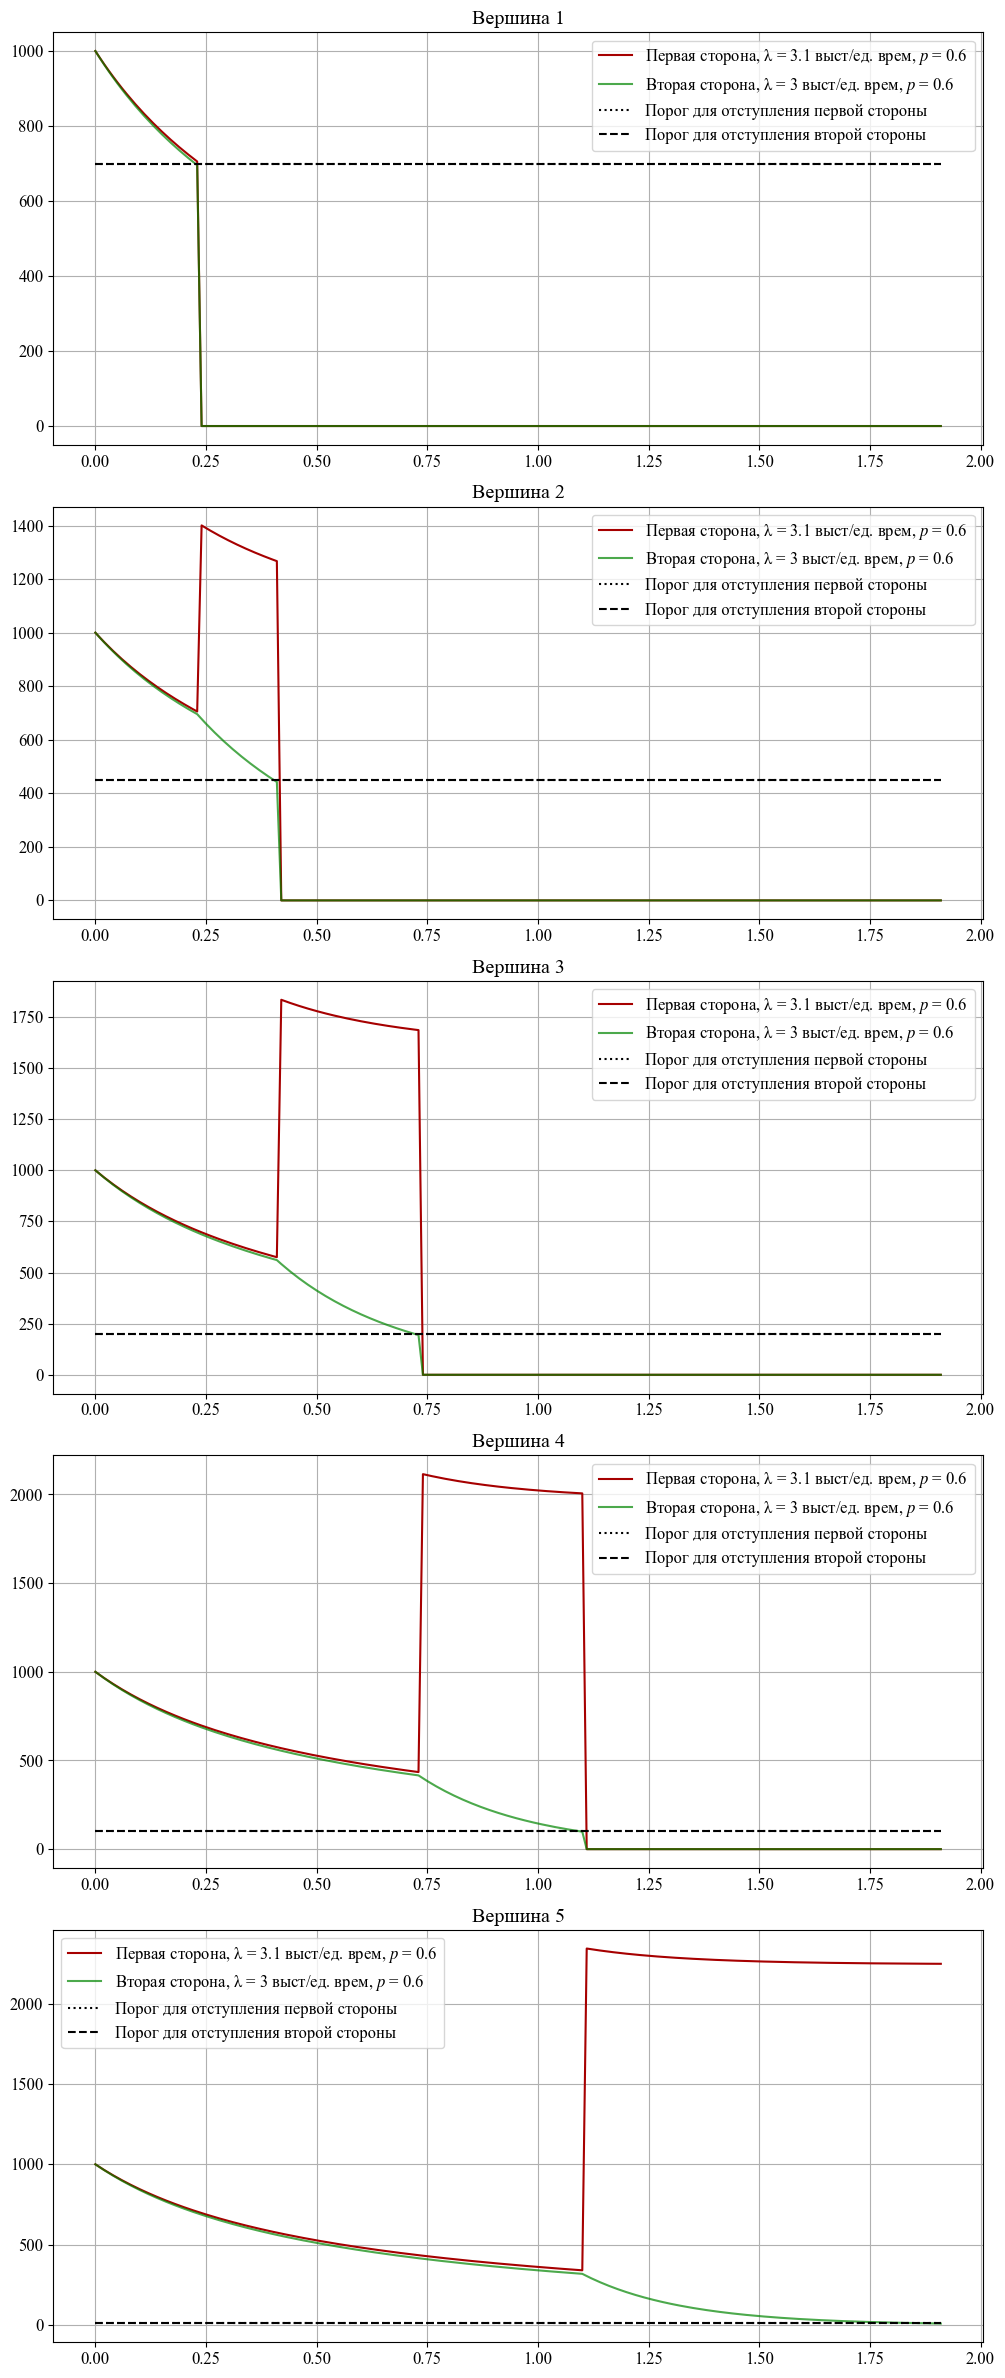

In [9]:
graph_3.plot_results()